In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# Produce optimal solution for Workshop 2

In [2]:
df_full = pd.read_csv('../data/transformed_data_raw.csv', index_col = 0)
df_full.head()

,Mobile Traffic,Time Spend On YouTube [min],Time Spend On TikTok [min],Time Spend On Instagram [min],Time Spend On Spotify [min],Size of home [m2],Occupation,Family Type,Family Interest,House Type,Number Of Residents,Average Age,Distance To Nearest Tower [m],Number Of Phones,Number Of Computers,Number Of Tvs,Number Of Pets,Customer Happiness
0,14.247892,4.841035,22.944832,8.550267,12.594165,146.609225,0.500000,0.00,0.000000,0.8,3,51,1192.903139,4,2,1,2,7.0
1,15.338043,8.758946,16.936287,11.869073,8.505793,160.408984,0.500000,0.00,0.666667,0.0,3,48,675.676827,3,2,1,2,4.0
2,15.549691,11.624994,22.654860,10.586650,11.537797,120.803378,0.333333,0.00,0.333333,0.8,3,50,1089.151712,3,3,2,2,7.0
3,8.352014,10.208889,11.039776,10.756086,3.705005,59.421367,0.333333,0.25,0.833333,0.4,2,72,1733.641943,3,3,1,1,4.0
4,13.770765,12.622379,9.440595,12.128573,21.965783,132.736281,0.833333,0.75,0.500000,0.0,4,60,1204.166370,4,3,2,2,1.0


In [3]:
# # Hide last 200 observations for testing 
# df_unseen = df_raw[-200:]
# df = df_raw[:-200]


In [4]:

variables = list(df_full.columns)
target_var = "Mobile Traffic"
variables.remove(target_var)

# standardizing dataframe so coefficients are -1 and 1
df_full_z = df_full.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)

# Store mean and std to transform back 
mean_std={}
for var in df_full.columns:
    mean_std[var]=(df_full[var].mean(), df_full[var].std())

def reverse_zscore(pandas_series, mean, std):
    '''Mean and standard deviation should be of original variable before standardization'''
    yis=pandas_series*std+mean
    return yis

original_mean, original_std = mean_std[target_var]
original_var_series = reverse_zscore(df_full_z[target_var], original_mean, original_std)

Y_full_actual = df_full[target_var]
print("Prepared data")

Prepared data


In [5]:
df_z =  df_full_z[:-200]
Y_actual = Y_full_actual[:-200]

df_test_z = df_full_z[-200:]
Y_test_actual = Y_full_actual[-200:]


In [6]:
prediction_log = []
prediction_log_df = pd.DataFrame(columns = [
    "Time",
    "Mean Absolute Error", 
    "Mean Percentage Error",
    "Weights"
])

In [7]:
def manual_predict(weights):
    # Manually calculate y = alpha * x + beta
    X = df_z.copy()
    Y = X.pop(target_var)
    for i in X.columns:
        alpha = weights[i]
        X[i] = df_z[i] * alpha 
    Y_pred = X.sum(axis=1)
    
    Y_pred_trans = reverse_zscore(Y_pred, original_mean, original_std)

    return Y_pred_trans

def verify():
    record_log = prediction_log_df.sort_values("Mean Absolute Error").iloc[0,:]
    w = record_log.pop("Weights")
    print(f"The record log:")
    print(record_log)
    print(f"with Weights: ")
    print(pd.Series(w))
    y_p = manual_predict(w)
    mae = calc_mae(Y_actual, y_p)
    print(f"The calculated MAE: {mae}")

def calc_mae(Y_a, Y_p):
    return sum(abs(Y_a - Y_p))/len(Y_a)

In [8]:
import statsmodels.api as sm
X = df_z.copy()
Y = X.pop(target_var)
results = sm.OLS(Y,X).fit()
Y_train_pred_trans = reverse_zscore(results.fittedvalues, original_mean, original_std)
print(np.mean(abs(Y_actual - Y_train_pred_trans)))

results.summary()  

0.7221036970377047


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         Mobile Traffic   R-squared (uncentered):                   0.927
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                              735.5
Date:                Wed, 18 Sep 2024   Prob (F-statistic):                        0.00
Time:                        13:58:21   Log-Likelihood:                         -120.83
No. Observations:                1000   AIC:                                      275.7
Df Residuals:                     983   BIC:                                      359.1
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Time Spend On YouTube [min]       0.2334      0.012     19.186      0.000       0.210       0.257
Time Spend On TikTok [min]        0.2267      0.012     18.738      0.000       0.203       0.250
Time Spend On Instagram [min]     0.1031      0.010     10.779      0.000       0.084       0.122
Time Spend On Spotify [min]       0.0400      0.010      4.183      0.000       0.021       0.059
Size of home [m2]                 0.1662      0.011     15.166      0.000       0.145       0.188
Occupation                        0.0096      0.009      1.090      0.276      -0.008       0.027
Family Type                      -0.0312      0.009     -3.440      0.001      -0.049      -0.013
Family Interest                  -0.0885      0.011     -8.037      0.000      -0.110      -0.067
House Type                       -0.0300      0.009     -3.365      0.001      -0.047      -0.013
Number Of Residents               0.2484      0.016     15.768      0.000       0.217       0.279
Average Age                      -0.3673      0.016    -22.585      0.000      -0.399      -0.335
Distance To Nearest Tower [m]     0.0442      0.014      3.253      0.001       0.018       0.071
Number Of Phones                  0.1473      0.013     11.530      0.000       0.122       0.172
Number Of Computers               0.0156      0.010      1.533      0.125      -0.004       0.035
Number Of Tvs                    -0.0019      0.009     -0.209      0.834      -0.020       0.016
Number Of Pets                   -0.0094      0.009     -1.071      0.284      -0.027       0.008
Customer Happiness                0.2489      0.011     22.936      0.000       0.228       0.270
==============================================================================
Omnibus:                        3.097   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                3.151
Skew:                          -0.133   Prob(JB):                        0.207
Kurtosis:                       2.934   Cond. No.                         5.15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
X_test = df_test_z.copy()
Y_test = X_test.pop(target_var)
Y_test_pred = results.predict(X_test)


0.7184338764840362


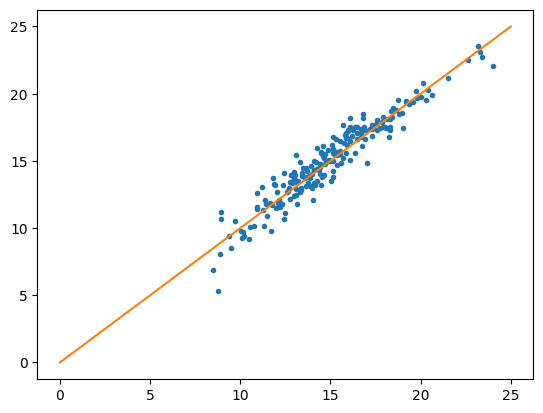

In [10]:

from matplotlib.pylab import plot
Y_test_pred_trans = reverse_zscore(Y_test_pred, original_mean, original_std)

print(np.mean(abs(Y_test_actual - Y_test_pred_trans)))

plot(Y_test_pred_trans,Y_test_actual,'.')
plot(np.linspace(0,25,10),np.linspace(0,25,10))

# Optimal solution for Workshop 3